# A Tutorial in Using MedImageInsight for Zero-Shot Classification of Chest Pathologies

MedImageInsight is a versatile foundational model that can be used for a range of computer vision tasks. In this tutorial, we will explore how to create a classifier for 2D chest X-rays using a zero-shot approach. This method leverages the information already encoded in MedImageInsight, aligning text labels with images without additional training. When embarking on building a machine learning system for visual classification, starting with a zero-shot approach like this can establish a baseline for further experiments. The GPU costs with using the zero-shot method are minimal since there are no training runs, and you typically only run a few inferences on a test set.

This tutorial also explores methods to evaluate the performance of the classifier and provides visualizations.

## Prerequisites

This notebook requires the following setup. If you haven't completed these steps, please refer to the Getting Started section in the main README, which includes:

1. Deploying required models
2. Installing the Healthcare AI Toolkit
3. Downloading sample data
4. Configuring your `.env` file

### Required for This Notebook

- **Model Endpoint(s)**: `MI2_MODEL_ENDPOINT` 
- **Additional Dependencies**: None

## Zero-Shot Classification Overview
This tutorial will walk you through the steps of using the MedImageInsight embedding model to compute embeddings of an image collection and then classify these images using a set of predefined classes. Here are the steps we will perform:

1. **Generate Image and Text Embeddings from 2D Chest X-Rays and Perform Zero-Shot Predictions**
    - **Image Embeddings**: We will send a dataset of chest X-ray dicoms to MedImageInsight endpoint to obtain a set of embedding vectors corresponding to each image
    - **Text Embeddings**: We will use a set of text descriptors to provide 5 different Chest pathology labels (1. No Finding, 2. Support Devices, 3. Pleural Effusion, 4. Cardiomegaly and 5. Atelectasis) and will compute embedding vectors for these text descriptions.
    - **Similarity Calculation**: We will find the similarity between each image feature vector and each text feature vector by calculating the dot product, effectively computing probabilities of images belonging to each particular class.
    
2. **Compare Zero-Shot Predictions with Ground Truth Labels**
    - Since our data comes with ground truth labels, we will compare them to the predictions made by MedImageInsight to evaluate the model's performance.

3. **Visualize Images with the Corresponding Zero-Shot Prediction**
    - Qualitative representations provide an alternative way to assess the correctness of the correspondences with the zero-shot predictions.
    - We will select four subjects (two with accurate predictions and two with an incorrect prediction) to visualize the image-text correspondence.

## 1. Setup and Imports

In [ ]:
## Install the required packages through requirements.txt with the below command code before running the tutorial

## Load Packages for the tutorial
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import SimpleITK as sitk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppress SimpleITK warnings
sitk.ProcessObject_SetGlobalWarningDisplay(False)

### Deploy Online Endpoint
Here we adapt MedImageInsight as an online endpoint generated from [mi2-deploy.ipynb](./mi2-deploy.ipynb) with the following input.

### Input Data 

- **Data Distribution per class:**
  1. No Finding (20 Subjects)
  2. Support Devices (20 Subjects)
  3. Pleural Effusion (20 Subjects)
  4. Cardiomegaly (20 Subjects)
  5. Atelectasis (20 Subjects)

- **Computing Image Embeddings:** Our source images are in DICOM format, as typical for radiological images. During inference, we extract the image pixel bytes and convert them to 8-bit monochromatic bitmap for compatibility with MedImageInsight. We then compute image embeddings for each image using the MedImageInsight model.

**Text**
- We provide the pathology class information as text (chest_pathology_text) to enable zero-shot classification. 
- Our zero-shot classification method essentially tries to determine which of the text statements describing each class is closest to the images in the MedImageInsight embedding space. 
    - For example, a text descriptor like "x-ray chest anteroposterior Cardiomegaly" can be broken down into hierarchical semantics: 
        1. **Imaging Modality**: x-ray
        2. **Body Anatomy**: chest
        3. **Imaging Orientation**: anteroposterior
        4. **Pathology**: Cardiomegaly

In [ ]:
from healthcareai_toolkit import settings

## Input Images and Text for Inference
data_root = settings.DATA_ROOT

if not os.path.exists(data_root):
    raise (
        Exception(
            f"Please download the files as described in this notebook into the data_root: {data_root}"
        )
    )

## Load image input folder for generating image embeddings
input_folder = os.path.join(data_root, "medimageinsight-classification", "images")
## Load csv folder labels and splits
csv_folder = os.path.join(data_root, "medimageinsight-classification", "csv")

## For Text
## You can add your own text or use the below text for inference
chest_pathology_text = [
    "x-ray chest anteroposterior No Finding",
    "x-ray chest anteroposterior Support Devices",
    "x-ray chest anteroposterior Pleural Effusion",
    "x-ray chest anteroposterior Cardiomegaly",
    "x-ray chest anteroposterior Atelectasis",
]

## 2. Zero-Shot Classification Inference with Image & Text Embedding Generation

This section demonstrates how MedImageInsight performs zero-shot classification by independently computing text and image embeddings. It then uses the dot product and softmax function to obtain probabilities of the image belonging to different classes based on the similarity with the text embeddings.

### 2.1. Compute Embeddings: 
First, we compute embeddings for both the image and the text data. These embeddings are unique representations that capture:

- The semantic meaning of the text.
- The visual content of the image.

**Note:**  This will use your deployed AzureML endpoint.  Check that is setup and you have a deployment accepting traffic.

In [ ]:
from healthcareai_toolkit.clients import MedImageInsightClient


endpoint = settings.MI2_MODEL_ENDPOINT
mi2_client = MedImageInsightClient(endpoint)
submitter = mi2_client.create_submitter()

Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


In [ ]:
import glob

image_files = list(glob.glob(input_folder + "/*.dcm"))

_, text_results = submitter.submit(
    text_list=chest_pathology_text, total=len(chest_pathology_text)
)
_, image_results = submitter.submit(image_list=image_files, total=len(image_files))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.93s/it]


In [ ]:
name_list = [os.path.basename(f) for f in image_files]

image_features = np.vstack([v["image_features"] for v in image_results])
text_features = np.vstack([v["text_features"] for v in text_results])
scaling_factor = np.atleast_1d(image_results[0]["scaling_factor"])

print(image_features.shape, text_features.shape, scaling_factor.shape)

(100, 1024) (5, 1024) (1,)


### 2.2. Calculate Image-Text Similarity: 
The embeddings that MedImageInsight model outputs are normalized as a part of inference code, therefore we should be able to directly compare cosine similarity metrics during the evaluation. We compute the similarity by taking the dot product of the image and text embeddings. This process helps us determine the probabilities of each image belonging to different classes as follows:
- We compute a dot product of text embeddings and image embeddings to obtain cosine similarity vector where each dimension contains the similarity score between a given image and a given label - the logits that we will turn into probabilities. 
- We apply a scaling factor - the temperature parameter that was learned during the training of MedImageInsight model. This factor is packaged with the model and returned during the API call, as shown in the code. Application of the scaling factor helps ensure that our logits are more evenly distributed. For more details refer to the [Unified Contrastive Learning paper](https://arxiv.org/pdf/2204.03610) that describes the training objective of MedImageInsight model. 
- We then apply the softmax function to obtain probabilities that are all distributed on a scale of [0..1]

In [ ]:
## Perform zero-Shot classification across all images in the folder
logits_per_image = (
    torch.from_numpy(scaling_factor).exp()
    * torch.from_numpy((np.array(image_features)))
    @ torch.from_numpy(np.array(text_features)).t()
)
print(logits_per_image.shape)

torch.Size([100, 5])


### 2.3. Obtain Probabilities: 
Finally, we use the softmax function to convert the dot product values into probabilities for each text label class. The text label class with the highest probability is considered the zero-shot prediction outcome for the image.


In [ ]:
probs = logits_per_image.softmax(dim=-1).cpu().numpy()
print(probs.shape)

(100, 5)


## 3. Compare Zero-Shot Predictions with Corresponding Ground-Truth Labels
After the feature extraction process, the model generates zero-shot predictions for various pathology classes in chest X-rays from the demo dataset. In this section, we will compare these predictions with the corresponding ground-truth labels to evaluate the performance of the MedImageInsight model.

- **Evaluate Accuracy Using Ground-Truth Labels:**
    
    We compare the zero-shot predictions against the ground-truth labels, which represent the actual pathology classes present in the image samples. This comparison involves:
    - **Calculating Performance Metrics:** We compute metrics such as accuracy and F1-score to quantify the model's performance.
    - **Analyzing Results:** These metrics help us understand how well the model identifies each pathology class and highlight areas where the model may need improvement.
- **Compute Confusion Matrix to Visualize True Positive and False Positive Rates:**
    
    To gain deeper insights into the model's prediction patterns, we compute a confusion matrix:
    - **Visualization of Prediction Errors:** The confusion matrix displays the number of correct and incorrect predictions for each class, allowing us to see where misclassifications occur.
    - **Identifying Misclassification Trends:** By examining the confusion matrix, we can identify specific classes that are often confused with others, which can inform adjustments to the model or the text descriptor used in zero-shot classification.

Zero-Shot Classification Report:
                                               precision    recall  f1-score   support

      x-ray chest anteroposterior No Finding       0.52      0.75      0.61        20
 x-ray chest anteroposterior Support Devices       1.00      0.15      0.26        20
x-ray chest anteroposterior Pleural Effusion       0.65      0.75      0.70        20
    x-ray chest anteroposterior Cardiomegaly       0.54      0.75      0.63        20
     x-ray chest anteroposterior Atelectasis       0.71      0.60      0.65        20

                                    accuracy                           0.60       100
                                   macro avg       0.68      0.60      0.57       100
                                weighted avg       0.68      0.60      0.57       100



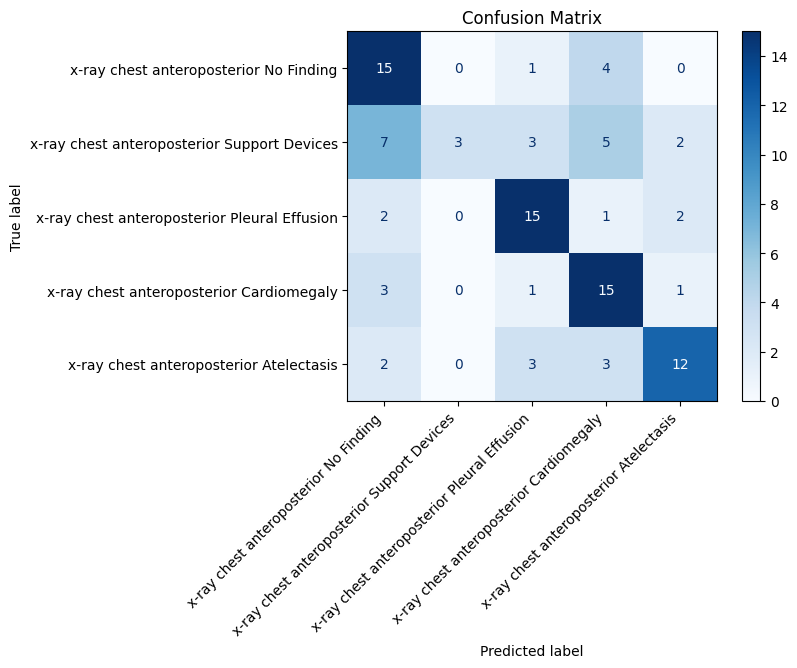

In [ ]:
from sklearn.metrics import classification_report

## Load Ground Truth Labels
findings_csv = os.path.join(f"{csv_folder}/dcm_sample_label.csv")
findings_df = pd.read_csv(findings_csv)

# Generate dictionary to organize all probabilities corresponding to name
pred_dict = {
    name: {"pred_text": chest_pathology_text[pred_label], "pred_label": pred_label}
    for name, pred_label in zip(name_list, np.argmax(probs, axis=1).tolist())
}

# Extract ground truth labels and categories
gt_dict = {
    name: {
        "label": findings_df[findings_df["Name"] == name]["Label"].values[0],
        "label_category": findings_df[findings_df["Name"] == name][
            "Label Category"
        ].values[0],
    }
    for name in name_list
}

# Prepare lists of predicted and ground truth labels
pred_label_list = [pred_dict[name]["pred_label"] for name in name_list]
gtlabel_list = [gt_dict[name]["label"] for name in name_list]

# Generate classification report
report = classification_report(
    gtlabel_list, pred_label_list, target_names=chest_pathology_text
)
print("Zero-Shot Classification Report:\n", report)
## Compute the confusion matrix
cm = confusion_matrix(gtlabel_list, pred_label_list)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=chest_pathology_text)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

This confusion matrix illustrates the performance of a classifier in distinguishing between five different classes, all related to chest X-ray findings: "No Finding," "Support Devices," "Pleural Effusion," "Cardiomegaly," and "Atelectasis."

**Key Insights:**
1. **Best Performance:**

    - The model performs best in identifying "Pleural Effusion" and "Atelectasis" with 15 correct predictions out of 19 samples for each of those classes. "No Finding" also has strong performance with 15 correct predictions out of 20 samples.

2. **Worst Performance**:

    - The worst performance appears to be in the "Support Devices" class, where only 2 out of 20 predictions were correct, with considerable misclassification into the "No Finding" and "Cardiomegaly" classes.
    - There are multiple misclassifications between "Support Devices" and other categories, which suggests confusion in detecting the presence of medical devices in the X-ray images.

**Misclassification Patterns:**

- There is significant overlap between "No Finding" and "Support Devices", as well as between "Cardiomegaly" and "Atelectasis."
- The model struggles to differentiate between some of the conditions, likely due to similar features or ambiguous presentations in the X-rays.

**Next Steps:**
- Training an adaptor model could target the high confusion areas, especially for the "Support Devices" class. In the next notebook in the series we will show how it could be done with relatively low effort and computation requirements. This can improve feature representation and focus on better distinction between similar-looking classes.

## 4. Visualize images with the corresponding zero-shot prediction and probabilities
In this section, we visualize images to evaluate the quality of our zero-shot classifier using specific examples. Previously, we compute the image-text correspondences and selected the text with the highest probability as our predicted labels to better match the ground truth.

We focus on four subjects:

- **Two subjects with accurate predictions:** These examples demonstrate cases where the classifier correctly identified the pathologies present in the images.
- **Two subject with an incorrect prediction:** This example highlights a case where the classifier's prediction did not match the ground truth, allowing us to analyze potential reasons for the misclassification.

By examining these images alongside their zero-shot predictions and associated probabilities, we can gain insights into:

- **Model Performance:** Understand how well the model captures the visual features corresponding to the text descriptions.
- **Areas for Improvement:** Identify patterns in mispredictions that could inform future refinements of the model or the text descriptor.

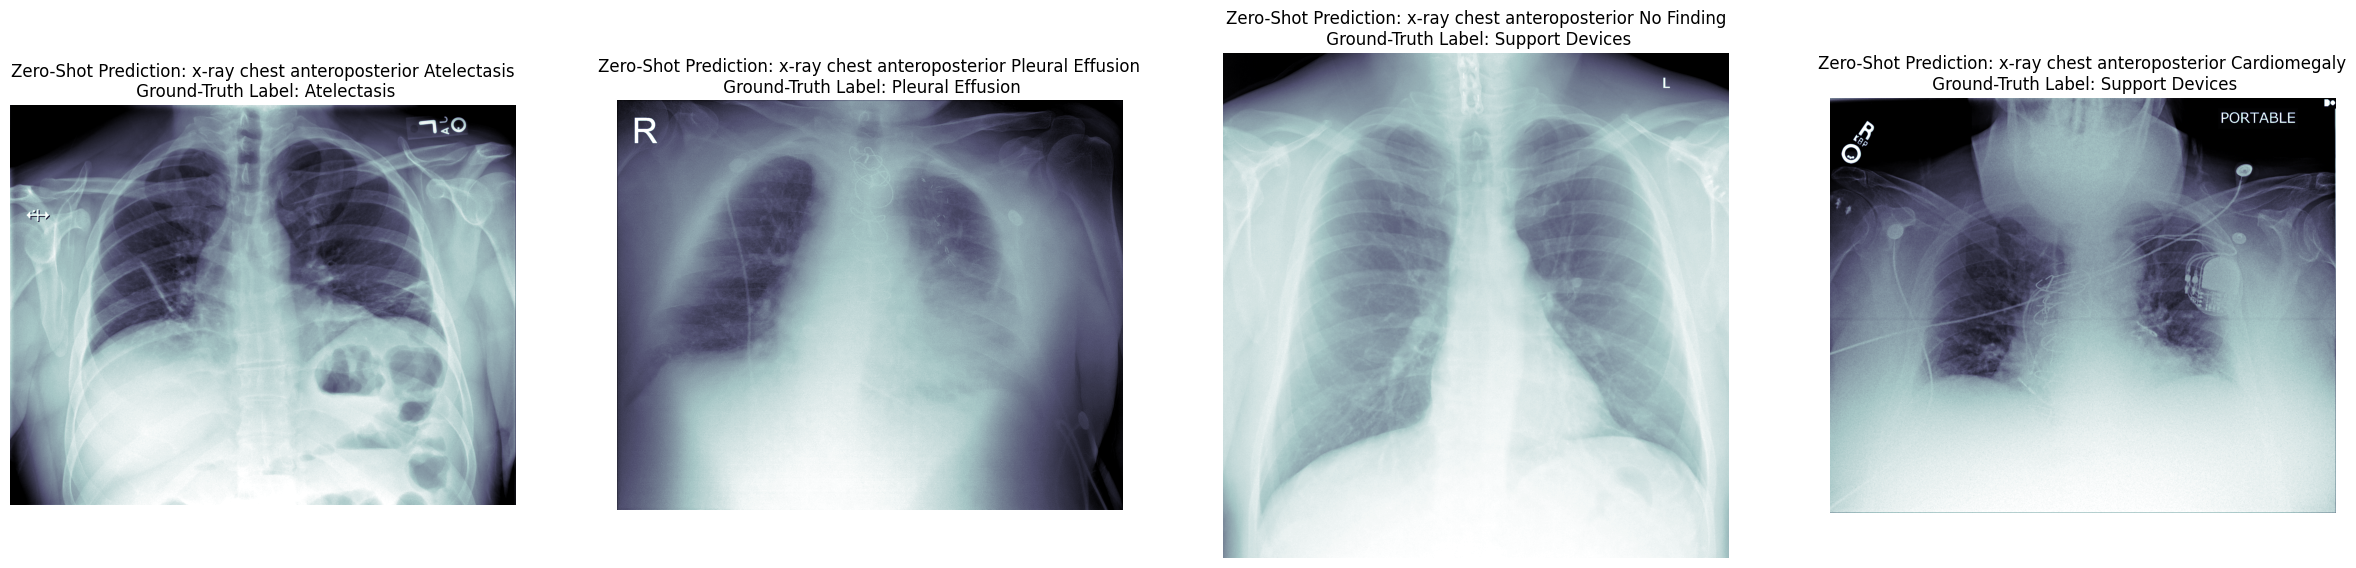

In [ ]:
## Organize and save the results for sample selection and visualization
df = pd.DataFrame(
    {
        "file_name": name_list,
        "zero_shot_pred": [pred_dict[name]["pred_text"] for name in name_list],
        "ground_truth_label": [gt_dict[name]["label_category"] for name in name_list],
    }
)
df.to_csv("./zero_shot_classification_results.csv", index=False)

# Select four images to visualize (Two correct examples and two failed examples)
selected_images = [
    "1.3.6.1.4.1.55648.013051327602219610100989737191708734008.2.1.green.dcm",
    "1.3.6.1.4.1.55648.045678110342520932233807899271374363433.1.1.green.dcm",
    "1.3.6.1.4.1.55648.255611619245397591591431066926543031128.1312.1.green.dcm",
    "1.3.6.1.4.1.55648.023647312006371870964474485493542161185.1.1.green.dcm",
]

selected_data = {
    image: {
        "selected_zero_shot_pred": df.loc[
            df["file_name"] == image, "zero_shot_pred"
        ].values[0],
        "selected_ground_truth_labels": df.loc[
            df["file_name"] == image, "ground_truth_label"
        ].values[0],
    }
    for image in selected_images
}

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
for i, image_name in enumerate(selected_images):
    prediction = selected_data[image_name]["selected_zero_shot_pred"]
    gt = selected_data[image_name]["selected_ground_truth_labels"]
    image_path = os.path.join(input_folder, image_name)
    image = mi2_client.read_and_normalize_image(image_path)
    axs[i].imshow(image, cmap="bone")
    axs[i].axis("off")
    axs[i].set_title(
        "Zero-Shot Prediction: {}\n Ground-Truth Label: {}".format(prediction, gt)
    )

plt.show()

## Final Remark:

Moving forward, we will focus on improving the model's performance using the same set of embeddings but applying a simple adaptor to enhance classification accuracy, particularly for the more classes such as "Support Devices." In the [Adapter Training](./adapter-training.ipynb), we will quantify and demonstrate the improvements in performance after integrating the adaptor model. This step will help refine the system's ability to distinguish between closely related classes and reduce misclassification rates, setting the stage for better results in the classification of chest X-ray images.

## See Also

### Continue Your Workflow with Healthcare AI Model Evaluator (HAIME)

Now that you've established a zero-shot baseline and generated predictions with MedImageInsight, continue your workflow **Healthcare AI Model Evaluator (HAIME)** to accelerate your journey from experimentation to annotation, evaluation, and model fine-tuning. HAIME is an open-source evaluation platform designed for healthcare AI, enabling multi-disciplinary teams to build and validate models on their own data and tasks with subject matter experts in the loop.

To explore this further, check how to [continue this workflow with HAIME](https://aka.ms/haime-zero-shot-workflow). In the guide you will learn to:

- **Leverage your existing predictions**: Import the `zero_shot_classification_results.csv` you just generated for immediate evaluation.
- **Multi-reviewer evaluation**: enable _human-in-the-loop validation_ by collecting feedback from Subject Matter Experts, and combine expert evaluation with _Model reviewers_ for comprehensive assessment.
- **Compute transparent metrics** with support for custom metrics that match your use-case.
- **Bridge to improvement**: Export annotations and evaluations for downstream training and analysis.